## 問題設定

状態ベクトルの次元$n=2$, 入力制御ベクトルの次元$m=1$とし, 線形システム

$$ \dot{x}(t) = Ax(t) + B u(t)$$

を考える. ここで
$$
A=\begin{bmatrix} 0 & 1\\ -6&-2\end{bmatrix},\quad
B=\begin{bmatrix} 0\\1 \end{bmatrix}
$$
とし, 初期値は
$$
x(0)=\begin{bmatrix} -1\\ 0\end{bmatrix}
$$

とする. 評価関数は

$$
J=\dfrac12 x^T(T) S_Tx(T) + \int_0^T\dfrac12\left(x^T(t)Qx(t) + u^T(t)Ru(t)\right)\, dt, \quad T=1.5
$$

において
$$
S_f=Q=\begin{bmatrix} 13& 0\\ 0&1\end{bmatrix},\quad
R=\begin{bmatrix} 1 \end{bmatrix}
$$
とする. すなわち

$$
J=\dfrac12 \left(13x_1(T)^2 + x_2(T)^2 \right) +\dfrac12 \int_0^T\left(13x_1(t)^2 + x_2(t)^2 +u(t)^2\right)\, dt.
$$

を最小化する最適制御を考える.

オイラー・ラグランジュ方程式

$$\begin{aligned}
&\dot{x}(t) = Ax(t) + Bu(t),
\quad x(0)=x_0, \\
&\dot{\lambda}(t) =-Qx(t)-A^T \lambda(t) , 
\quad \lambda(t_f) =  S_f (x(t_f)), \\
&u^T(t)R + \lambda^T(t)B=0.
\end{aligned}$$

に対して, ハミルトニアンを$H=L+\lambda^T f$とする.

以下のアルゴリズムを構築する

1. 適当な$u$を制御入力の初期推定解とする
2. $u$を用いて状態方程式を解いて$x$を求める
3. 随伴方程式を解いて$\lambda$を求める
4. $x$,$u$,$\lambda$から$\frac{\partial H}{\partial u}$を計算する. 
    * 勾配のノルム$\left(\int_{t_0}^{t_f}\left\|\frac{\partial H}{\partial u}\right\|^2\right)^{\frac{1}{2}}$が十分小さければ停止する
5. $s=-\left(\frac{\partial H}{\partial u}\right)^T$とおく
6. 制御入力を $u+\alpha s$としたときの評価関数値$J[u+\alpha s]$が最小になるスカラー$\alpha$を求め, $u=u+\alpha s$と更新してステップ2に戻る

In [3]:
import diffrax
import jax.numpy as jnp
from tqdm.notebook import tqdm_notebook as tqdm

# 問題設定
A = jnp.array([[0, 1], [-6, -2]], dtype=float)
B = jnp.array([[0], [1]], dtype=float)

S_f = jnp.array([[13, 0], [0, 1]], dtype=float)
Q = jnp.array([[13, 0], [0, 1]], dtype=float)
R = jnp.array([[1]], dtype=float)

x_0 = jnp.array([[-1], [0]], dtype=float)

# 解く区間
t0, t1 = 0, 1.5
dt = 0.001

# diffrax の出力数
N = 1000

In [4]:
# まずはステップ２〜５を実装し切る
# 汎用設定
ts = jnp.linspace(t0, t1, N)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=ts)
# step1
u = jnp.ones((N, 1, 1))

In [5]:
# step2 x を求める
def vector_field_x(t, x, args):
    u_t = args.evaluate(t)
    dot_x = A @ x + B @ u_t
    return dot_x


state_eq = diffrax.ODETerm(vector_field_x)

In [6]:
# step3 lambda を求める
def vector_field_lambda(t, lambda_, args):
    x_t = args.evaluate(t)
    # 時間逆向きに解くので、符号を反転
    dot_lambda = Q @ x_t + A.T @ lambda_
    return dot_lambda


lambda_eq = diffrax.ODETerm(vector_field_lambda)

In [24]:
import jax


# step 4. $x$,$u$,$\lambda$からハミルトニアンとその勾配を求める
@jax.jit
def hamiltonian(x, u, lambda_):
    L = 0.5 * (jnp.matmul(x.T, jnp.matmul(Q, x)) + jnp.matmul(u.T, jnp.matmul(R, u)))
    f = jnp.matmul(A, x) + jnp.matmul(B, u)
    H = L + jnp.matmul(lambda_.T, f)
    return H.squeeze()


@jax.jit
def compute_hamiltonian_and_gradients(x, u, lambda_):
    """
    各時刻におけるハミルトニアンとその u に関する勾配を計算します。

    Parameters:
    x (jnp.array): 状態変数、形状は (N, n, 1)
    u (jnp.array): 制御入力、形状は (N, m, 1)
    lambda_ (jnp.array): ラグランジュ乗数、形状は (N, n, 1)

    Returns:
    Tuple[jnp.array, jnp.array]: ハミルトニアンの配列と勾配の配列
    """
    # ベクトル化されたハミルトニアン関数
    H = jax.vmap(hamiltonian, in_axes=(0, 0, 0))(x, u, lambda_)
    # ベクトル化された勾配関数
    hamiltonian_grad_u = jax.grad(hamiltonian, argnums=1)
    grad_u = jax.vmap(hamiltonian_grad_u, in_axes=(0, 0, 0))(x, u, lambda_)
    return H, grad_u

In [25]:
from scipy.optimize import minimize_scalar


@jax.jit
def compute_J(x, u):
    N = x.shape[0]  # サンプル数
    dt = (t1 - t0) / N  # 時間刻み

    x_T = x[-1]  # 最後の時刻の状態, 形状は (n, 1)
    terminal_cost = 0.5 * jnp.matmul(x_T.T, jnp.matmul(S_f, x_T)).squeeze()

    xQx = jnp.einsum("nkj,ki,nij->n", x, Q, x)  # 形状は (N,)
    uRu = jnp.einsum("nkj,ki,nij->n", u, R, u)  # 形状は (N,)
    integral_cost = 0.5 * jnp.sum(xQx + uRu) * dt

    # 総コスト J の計算
    J = terminal_cost + integral_cost
    return jnp.sum(J)


@jax.jit
def J_alpha(alpha, u, s, x):
    u_new = u + alpha * s
    return compute_J(x, u_new)

In [29]:
u = jnp.ones((N, 1, 1))
for i in tqdm(range(1000)):
    # step2 u から x
    u_func = diffrax.LinearInterpolation(ts=ts, ys=u)
    sol = diffrax.diffeqsolve(state_eq, solver, t0, t1, dt, x_0, args=u_func, saveat=saveat)
    x = sol.ys

    # step3 x から lambda
    lambda_tf = S_f @ x[-1]
    x_func = diffrax.LinearInterpolation(ts=ts, ys=x[::-1])
    sol = diffrax.diffeqsolve(lambda_eq, solver, t0, t1, dt, lambda_tf, args=x_func, saveat=saveat)
    lambda_ = sol.ys[::-1]

    # step4 hamiltonian と勾配
    H, grad_u = compute_hamiltonian_and_gradients(x, u, lambda_)

    # step5 u の更新
    grad_norm = jnp.sqrt(jnp.sum(grad_u**2) * dt)
    s = -grad_u / grad_norm
    alpha_opt = minimize_scalar(J_alpha, bounds=(0, 1e9), method="bounded", args=(u, s, x)).x
    score = compute_J(x, u)
    if i % 100 == 0:
        print(f"{score=:.4f}, {grad_norm=:.4f}")

    u += alpha_opt * s

  0%|          | 0/1000 [00:00<?, ?it/s]

score=5.8079, grad_norm=2.4091
score=3.5545, grad_norm=0.6917
score=3.5510, grad_norm=0.6859
score=3.5483, grad_norm=0.6814
score=3.5460, grad_norm=0.6773
score=3.5444, grad_norm=0.6746
score=3.5427, grad_norm=0.6717
score=3.5416, grad_norm=0.6698
score=3.5403, grad_norm=0.6676
score=3.5394, grad_norm=0.6660


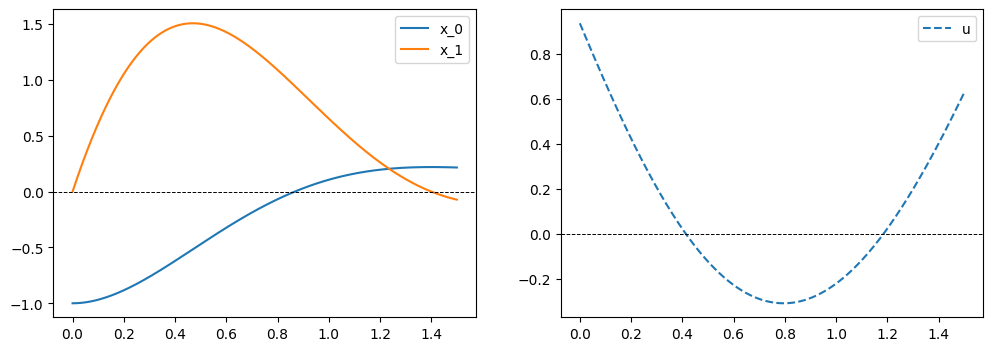

In [28]:
import matplotlib.pyplot as plt

X = jnp.array(x).reshape(N, 2)
U = jnp.array(u).reshape(N, 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for k in range(2):
    plt.plot(ts, X[:, k], label=f"x_{k}")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.legend()

plt.subplot(1, 2, 2)
for k in range(1):
    plt.plot(ts, U[:, k], linestyle="--", label="u")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.legend()
plt.show()

In [31]:
# 上の例は収束が遅いが, 十分に最適解に近ければ動かない
loaded_u = jnp.load("u.npy")

In [33]:
u = loaded_u
for _ in range(10):
    # step2 u から x
    u_func = diffrax.LinearInterpolation(ts=ts, ys=u)
    sol = diffrax.diffeqsolve(state_eq, solver, t0, t1, dt, x_0, args=u_func, saveat=saveat)
    x = sol.ys

    # step3 x から lambda
    lambda_tf = S_f @ x[-1]
    x_func = diffrax.LinearInterpolation(ts=ts, ys=x[::-1])
    sol = diffrax.diffeqsolve(lambda_eq, solver, t0, t1, dt, lambda_tf, args=x_func, saveat=saveat)
    lambda_ = sol.ys[::-1]

    # step4 hamiltonian と勾配
    H, grad_u = compute_hamiltonian_and_gradients(x, u, lambda_)

    # step5 u の更新
    grad_norm = jnp.sqrt(jnp.sum(grad_u**2) * dt)
    s = -grad_u / grad_norm
    alpha_opt = minimize_scalar(J_alpha, bounds=(0, 1e9), method="bounded", args=(u, s, x)).x
    score = compute_J(x, u)
    print(f"{score=:.4f}, {grad_norm=:.4f}")

    u += alpha_opt * s

score=3.3653 grad_norm=0.2189
score=3.3653 grad_norm=0.2189
score=3.3653 grad_norm=0.2189
score=3.3653 grad_norm=0.2189
score=3.3653 grad_norm=0.2189
score=3.3653 grad_norm=0.2189
score=3.3653 grad_norm=0.2189
score=3.3653 grad_norm=0.2189
score=3.3653 grad_norm=0.2189
score=3.3653 grad_norm=0.2188


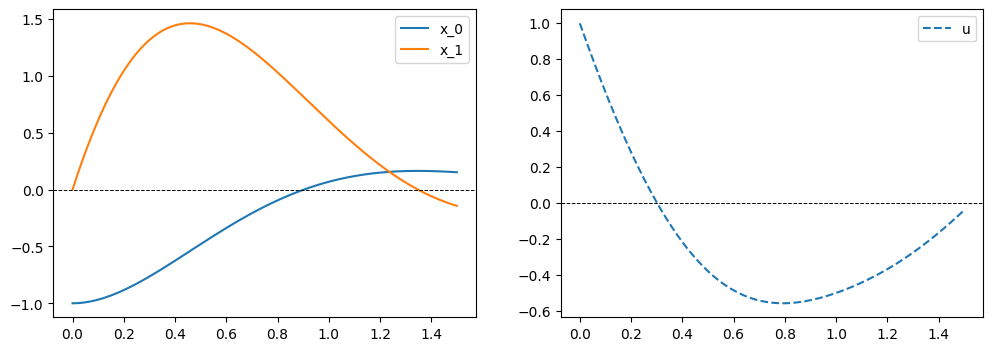

In [21]:
import matplotlib.pyplot as plt

X = jnp.array(x).reshape(N, 2)
U = jnp.array(u).reshape(N, 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for k in range(2):
    plt.plot(ts, X[:, k], label=f"x_{k}")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.legend()

plt.subplot(1, 2, 2)
for k in range(1):
    plt.plot(ts, U[:, k], linestyle="--", label="u")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.legend()
plt.show()